# Import libraries
Start by importing pytorch & matplotlib. 

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from IPython.display import set_matplotlib_formats
import matplotlib
import numpy as np
#%% matplotlib setup
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = "14"
mps_device = torch.device("mps")

# Create the functions

The separability proprieties of several functions are investigated. This code first shows the separability proprieties of different ways of clustering the 1D space into two regions. 
Two types of functions are used to do so:
* A sharp step function (Heaviside),
* A smooth one (Tanh).

In both cases the position of the jump is parametrised by a scalar parameter $\alpha$. 

Furhter investigations are conducted on moving front(s) with a 
* A gaussian function that is moving 
* Two gaussian functions moving at different rates

In [2]:
L = 10                                      # Space domain
Alpha_vect = torch.linspace(0,1,100)        # vector of alphas
x_vect = torch.linspace(0,L,2000)           # vector of x


Function = 'Heaviside'                      # Alpha-parameterised step function
Function = 'Tanh'                           # smooth alpha-parameterised step function
# Function = 'Gauss'                        # Alpha-parameterised front function
# Function = 'Gauss_sum'                      # Double alpha-parameterised front functions




if Function == 'Heaviside':
    F = torch.heaviside((x_vect[:,None] - (1-Alpha_vect[None,:])*L), x_vect[-1]/x_vect[-1])
elif Function == 'Tanh':
    F = torch.tanh((x_vect[:,None] - (1-Alpha_vect[None,:])*L))
elif Function == 'Gauss':
    F = torch.exp(-(x_vect[:,None] - (1-Alpha_vect[None,:])*L)**2)

elif Function == 'Gauss_sum':
    F = torch.exp(-(x_vect[:,None] - (1-Alpha_vect[None,:])*L)**2) + torch.exp(-(x_vect[:,None] - (1-2*Alpha_vect[None,:])*L)**2) 



<ipython-input-2-d944a66afc65>:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/aten/src/ATen/native/TensorShape.cpp:3618.)
  F_val = F_val.T


# Define the autoencoder

In [ ]:

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.N_0 = 2000
        self.N_1 = 1000
        self.N_2 = 200
        self.N_3 = 1
        self.encoder = nn.Sequential(
        nn.Linear(self.N_0,self.N_1),
        nn.Tanh(),
        nn.Linear(self.N_1, self.N_2),
        nn.Tanh(),
        nn.Linear(self.N_2, self.N_3)
        )

        self.decoder = nn.Sequential(
        nn.Linear(self.N_3,self.N_2),
        nn.ReLU(),
        nn.Linear(self.N_2, self.N_1),
        nn.ReLU(),
        nn.Linear(self.N_1, self.N_0)
        )
    
    def forward(self, x, role = "decode"):
        if self.training:
            e = self.encoder(x)
            d = self.decoder(e)
            return d
        else:
            match role:
                case "encode":
                    e = self.encoder(x)
                    return e
                case "decode":
                    d = self.decoder(x)
                    return d

ROM = AutoEncoder()
MSE = nn.MSELoss()

optimizer = torch.optim.Adam(ROM.parameters(),
                             lr = 1e-3)


# Create validation and training sets

In [ ]:

n_epochs = 400
import random
val = int(np.floor(0.2*F.shape[1]))
F_train = F
for n in range(val):
    r = random.randint(1, F_train.shape[1]-1)
    F_val = F_train[:,r]
    F_train = torch.cat([F_train[:, :r], F_train[:, r+1:]], dim=1)

F_train = F_train.T
F_val = F_val.T

loss_t_vect = []
loss_v_vect = []

# Train the model

In [3]:
ROM.train()
F_train = F_train.to(mps_device)
F_val = F_val.to(mps_device)
ROM.to(mps_device)
for epochs in range(n_epochs):
    loss = MSE(ROM(F_train),F_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_t_vect.append(loss.data)
    loss_v_vect.append(MSE(ROM(F_val),F_val).data)
    print(f'epoch {epochs+1} loss = {np.format_float_scientific(loss.item(), precision=4)}')

epoch 1 loss = 8.2215e-01
epoch 2 loss = 7.5591e-01
epoch 3 loss = 6.4768e-01
epoch 4 loss = 4.9854e-01
epoch 5 loss = 4.7980e-01
epoch 6 loss = 4.2160e-01
epoch 7 loss = 3.4246e-01
epoch 8 loss = 3.2619e-01
epoch 9 loss = 2.9568e-01
epoch 10 loss = 2.5512e-01
epoch 11 loss = 2.4586e-01
epoch 12 loss = 2.3931e-01
epoch 13 loss = 2.3153e-01
epoch 14 loss = 2.2087e-01
epoch 15 loss = 2.0926e-01
epoch 16 loss = 1.9862e-01
epoch 17 loss = 1.9227e-01
epoch 18 loss = 1.8806e-01
epoch 19 loss = 1.7965e-01
epoch 20 loss = 1.7307e-01
epoch 21 loss = 1.6381e-01
epoch 22 loss = 1.5461e-01
epoch 23 loss = 1.4275e-01
epoch 24 loss = 1.3477e-01
epoch 25 loss = 1.2472e-01
epoch 26 loss = 1.1645e-01
epoch 27 loss = 1.0558e-01
epoch 28 loss = 9.3668e-02
epoch 29 loss = 8.4703e-02
epoch 30 loss = 7.5422e-02
epoch 31 loss = 6.7268e-02
epoch 32 loss = 6.1574e-02
epoch 33 loss = 5.6306e-02
epoch 34 loss = 5.2063e-02
epoch 35 loss = 4.9823e-02
epoch 36 loss = 4.8173e-02
epoch 37 loss = 4.7084e-02
epoch 38 l

# Evaluate the model

In [4]:
ROM.eval()

F_train = F_train.cpu()
F_val = F_val.cpu()
ROM.cpu()
torch.save(ROM, 'FullModel.pt') # to save a full coarse model

# Plots

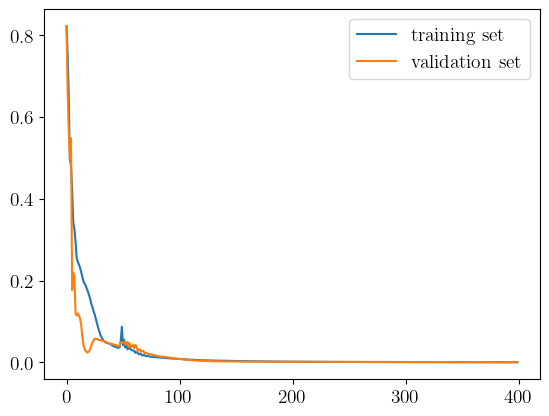

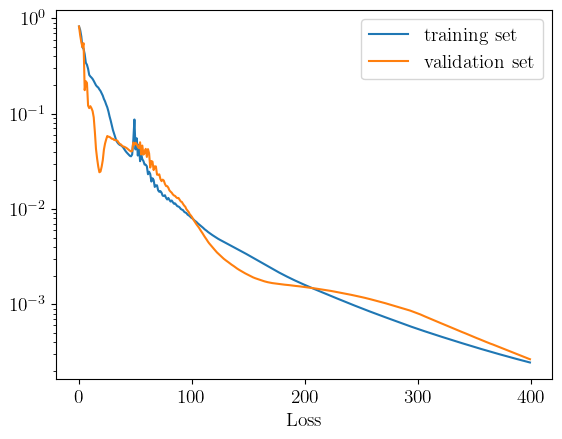

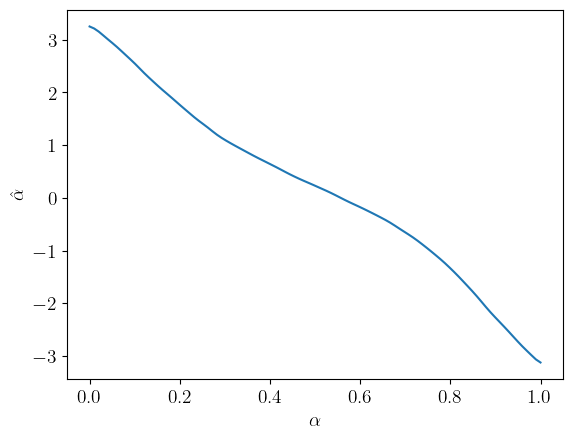

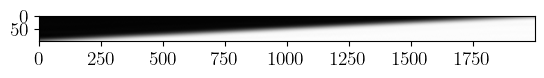

In [5]:
loss_t_vect = [loss_t.cpu() for loss_t in loss_t_vect]
loss_v_vect = [loss_v.cpu() for loss_v in loss_v_vect]


plt.plot(loss_t_vect,label = 'training set')
plt.plot(loss_v_vect,label = 'validation set')
plt.legend(loc="upper right")
plt.show()
plt.semilogy(loss_t_vect,label = 'training set')
plt.semilogy(loss_v_vect,label = 'validation set')
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.xlabel('Loss')
# plt.savefig(f'Results/loss_training_'+Function+'.pdf', transparent=True)  
plt.show()


# Plot the comparison of the latent space and the natural parameter used to generate the data

In [ ]:

Alpha_latent = ROM(F.t(),"encode")
plt.plot(Alpha_vect.view(-1,1).cpu().data,Alpha_latent.view(-1,1).cpu().data)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\hat{\alpha}$')
plt.show()


# Plot reconstructed image

In [ ]:
F_reconstructed = ROM(Alpha_latent.view(-1,1))
# F_reconstructed = ROM(Alpha_vect.view(-1,1))

plt.imshow(F_reconstructed.cpu().data,cmap='gray')
plt.show()

# Plot errors

## Error map

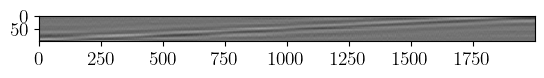

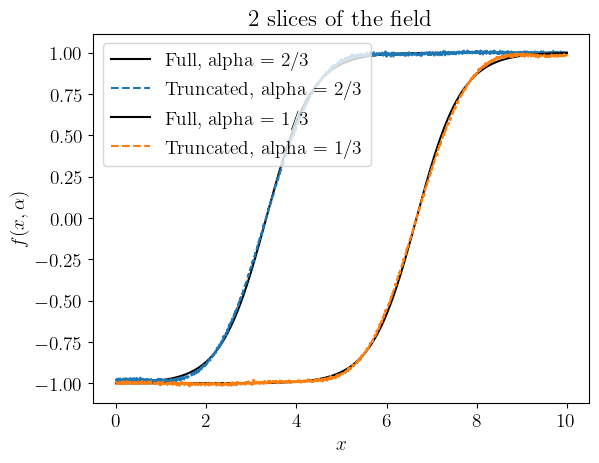

In [6]:
plt.imshow(F_reconstructed.cpu().data-F.t(),cmap='gray')
plt.show()


## Errors on sliced fields

In [ ]:

idx1 = int(np.floor(0.66*F.shape[1]))
idx2 = int(np.floor(0.33*F.shape[1]))

plt.plot(x_vect,F[:,idx1],'k',label='Full, alpha = 2/3')
plt.plot(x_vect,F_reconstructed.t()[:,idx1].cpu().data,'--',label='Truncated, alpha = 2/3')
plt.plot(x_vect,F[:,idx2],'k',label='Full, alpha = 1/3')
plt.plot(x_vect,F_reconstructed.t()[:,idx2].cpu().data,'--',label='Truncated, alpha = 1/3')
plt.legend(loc="upper left")
plt.title(f'2 slices of the field')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x,\alpha)$')
# plt.savefig(f'Results/Sliced_TruncatedField_{N}_'+Function+'.pdf', transparent=True)  
plt.show()

# Interactive comparison of the reconstructed field with regard to the reference

In [7]:
from ipywidgets import interact, widgets
import torch

def interactive_plot(alpha):
    
    plt.plot(x_vect,F[:,-alpha])
    plt.plot(x_vect,F_reconstructed.t()[:,-alpha].data)
    plt.show()

# Create an interactive slider
# slider_E1 = widgets.IntSlider(value=0, min=1, max=50, step=1, description='N modes')
slider_E2 = widgets.IntSlider(value=0, min=1, max=int(F.shape[1]-1), step=1, description='alpha')


# Connect the slider to the interactive plot function
interactive_plot_widget = interact(interactive_plot, alpha=slider_E2)

interactive(children=(IntSlider(value=1, description='alpha', max=99, min=1), Output()), _dom_classes=('widget…